In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import torch
# import minerl
from tqdm import tqdm
import random

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels
from collections import defaultdict
import coordconv

import collections

from ZerO import init_ZerO
from networks import SkippableLayerNorm
from lion_pytorch import Lion

In [4]:
class EnvSamplingWrapper:
    def __init__(self, env):
        self.env = env
        self.obs = env.reset()
        self.step_count = 0
        self.total_reward = 0
    
    def sample(self, count, policy):
        tuples = []
        rewards = []
        for i in range(count):
            self.step_count += 1
            action = policy(self.obs)
            observation, reward, done, info = env.step(action)
            tuples.append((self.obs, action, reward, observation, done))
            self.obs = observation
            self.total_reward += reward
            if done:
                self.obs = env.reset()
                rewards.append((self.total_reward, self.step_count))
                self.total_reward = 0
        
        return tuples, rewards


def prod(x):
    total = 1
    for i in x:
        total *= i
    return total


class DQN_Net(nn.Module):
    def __init__(self, input_size, action_size, zero=True):
        super().__init__()
#         print(input_size)
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.GELU(),
            nn.Linear(16, 16),
            nn.GELU(),
            nn.Linear(16, action_size),
        )
        if zero:
            with torch.no_grad():
                self.net[-1].weight[:,:] = 0
    
    def forward(self, x):
#         print(x.shape)
        x = torch.flatten(x, 1)
#         print(x.shape)
        x = self.net(x)
        return x

    
def dqn_policy(model, obs):
    # scale the obs, change to model shape
    image = torch.from_numpy(to_batch_shape(obs)).permute((0, 3, 1, 2)).cuda() / 255
    with torch.no_grad():
        outputs = model(image)
        action = torch.argmax(outputs).item()
    
    return action

In [5]:
"""
From https://github.com/rlcode/per/blob/master/SumTree.py
"""
import numpy


# SumTree
# a binary tree data structure where the parent’s value is the sum of its children
class SumTree:

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = numpy.zeros(2 * capacity - 1)
        self.data = numpy.zeros(capacity, dtype=object)
        self.n_samples = numpy.zeros(capacity)
        self.n_entries = 0
        self.write = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]
    
    def data_idx(self, idx):
        return (idx + self.capacity + 1) % self.capacity
    
    def tree_idx(self, d_idx):
        return d_idx + self.capacity - 1

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1
        return idx

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1
        self.n_samples[dataIdx] += 1

        return (idx, self.tree[idx], self.data[dataIdx])
    
    def get_at(self, idx):
        return (idx, self.tree[idx], self.data[self.data_idx(idx)])

In [6]:
# replay buffer. Store (s, a, r, s_n, d) tuples
class PrioritizedReplayBuffer:
    def __init__(self, max_size=1000000, epsilon=0.00001):
        self.tree = SumTree(max_size)
        self.epsilon = epsilon
    
    def add(self, s, a, r, s_n, d):
        self.tree.add(1, (s, a, r, s_n, d))
    
    def sample_batch(self, batch_size):
        batch = []
        chunk = self.tree.total() / batch_size
        for i in range(batch_size):
            item = self.tree.get(random.random() * chunk + i * chunk)
            batch.append(item)
        return batch
    
    def add_all(self, sarsd):
        for i in sarsd:
            buffer.add(*i)
    
    def update(self, idx, p):
        self.tree.update(idx, p + self.epsilon)

In [7]:
def sample_training_batch(buffer, batch_size):
    batch = buffer.sample_batch(batch_size)
    s = np.zeros((batch_size, 64, 64, 3), dtype='float32')
    a = np.zeros((batch_size, 1), dtype='int64')
    r = np.zeros((batch_size, 1), dtype='float32')
    s_n = np.zeros((batch_size, 64, 64, 3), dtype='float32')
    d = np.zeros((batch_size, 1), dtype='float32')

    
    for i, data in enumerate(batch):
        x = data[2]
        s[i] = x[0]
        a[i] = x[1]
        r[i] = x[2]
        s_n[i] = x[3]
        d[i] = x[4]
    
    s = torch.from_numpy(s).permute((0, 3, 1, 2)).cuda() / 255
    s_n = torch.from_numpy(s_n).permute((0, 3, 1, 2)).cuda() / 255
    a = torch.from_numpy(a).cuda()
    r = torch.from_numpy(r).cuda()
    d = torch.from_numpy(d).cuda()
    
    return s, a, r, s_n, d, batch

In [8]:
from DotEnvs import *

In [9]:
env = DotEnv()
STATS = defaultdict(list)

In [10]:
class CuriosityAlgorithm:
    def __init__(self, STATS):
        self.r_net = DQN_Net(prod(env.observation_space.shape), env.action_space.n, False).cuda()
        self.d_net = DQN_Net(prod(env.observation_space.shape), env.action_space.n, False).cuda()
        self.r_net.eval()
        self.optimizer = optim.AdamW(self.d_net.parameters(), lr=0.0001)
        self.train = True
        self.STATS = STATS
    
    def get_results(self, obs):
        # zero the parameter gradients
        self.optimizer.zero_grad(set_to_none=True)

        # forward + backward + optimize
        targets = self.r_net(obs).detach()
        outputs = self.d_net(obs)

        if torch.isnan(outputs).any():
            print("There's a NaN output!")
            return None
        individual_loss = torch.mean(F.smooth_l1_loss(outputs, targets, reduction='none'), -1, True)
#         print(individual_loss)
        loss = torch.mean(individual_loss)

        loss.backward()

        nn.utils.clip_grad_norm_(self.d_net.parameters(), max_norm=10.0)
        self.optimizer.step()
        self.STATS["curiosity_loss"].append(loss.detach().item())
        
        return individual_loss.detach()

In [11]:
curi = CuriosityAlgorithm(STATS)

In [355]:
def train_batch(model, target, buffer, optimizer, curiosity=None):
    # get the inputs
    
    # sample from the buffer and preprocess next qs
    s, a, r, s_n, d, batch = sample_training_batch(buffer, 32)
    
    # get the next qs
    with torch.no_grad():
        outputs = target(s_n)
        mq_n, ma_n = torch.max(model(s_n), 1)
#         print(outputs.shape, ma_n.shape)
        q_n = torch.gather(outputs, 1, ma_n.view(-1, 1))
#         print(q_n.shape)
#         q_n, a_n = torch.max(outputs, 1)
        # Avoid potential broadcast issue
        q_n = q_n.view(-1, 1)
#         print(q_n.shape)
        targets = r * (1.0) + q_n * (1 - d) * 0.99
    
    if curiosity:
        targets += curiosity.get_results(s)

    # zero the parameter gradients
    optimizer.zero_grad(set_to_none=True)
    
    # forward + backward + optimize
    outputs = model(s)
    
    # get the target action to diff the target with
    v = torch.gather(outputs, 1, a)

    if torch.isnan(outputs).any():
        print("There's a NaN output!")
        return None
    individual_loss = F.smooth_l1_loss(v, targets, reduction='none')
    loss = torch.mean(individual_loss)

    loss.backward()
    
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
    optimizer.step()
    
    for i, l in enumerate(individual_loss.detach().reshape(-1).tolist()):
        tree_idx = batch[i][0]
        tree = buffer.tree
        buffer.update(tree_idx, l)
        prev = tree.get_at(tree.tree_idx(tree.data_idx(tree_idx - 1)))
        # skip the wrap around states and terminal states
        if not prev[2] or prev[2][4]:
            continue
#         print(prev[0], prev[1], l)
        buffer.update(prev[0], prev[1] + l)
        
    return loss.detach().item()

In [356]:
def update_prev(buffer, tree_idx, l):
    tree = buffer.tree
    buffer.update(tree_idx, l)
    prev = tree.get_at(tree.tree_idx(tree.data_idx(tree_idx - 1)))
    print(prev)
    # skip the wrap around states and terminal states
    if not prev[2] or prev[2][4]:
        print("returning early")
        return
#         print(prev[0], prev[1], l)
    buffer.update(prev[0], prev[1] + l)

In [357]:
train_batch(model, target, buffer, optimizer, curi)

0.00029106985311955214

In [329]:
from utilities import soft_update
from basic_dqn import DQN_Policy

In [330]:
def dqn_loop(model, target, env_wrapper, buffer, optimizer, curiosity, steps, STATS):
    running_loss = None
    running_rew = 0
    
    next_exploration = 0.95
    with tqdm(range(steps), unit="batch") as t:
        for i in t:
            
            if i % 2500 == 0:
                policy = DQN_Policy(model, next_exploration, env_wrapper.env.action_space.sample)
                next_exploration -= 0.05
                next_exploration = max(next_exploration, 0.05)
            
            sarsd, rew = env_wrapper.sample(1, policy)
            buffer.add_all(sarsd)
            STATS['returns'].extend(rew)
            for r in rew:
                running_rew = running_rew * 0.99 + r[0] * 0.01
            
            if (i + 1) % 4 != 0:
                continue

            loss = train_batch(model, target, buffer, optimizer, curiosity)
            STATS["loss"].append(loss)

#             if i % 10000 == 0:
#                 soft_update(target, model, 1.0)
            soft_update(target, model, 0.001)
            if running_loss is None:
                running_loss = loss
            running_loss = running_loss * 0.999 + loss * 0.001
            if (i + 1) % 100 == 0:  # print every N mini-batches
                string = 'loss: %.8f, rew: %.8f' % (
                    running_loss, running_rew
                )
                t.set_postfix_str(string)

In [389]:
model = DQN_Net(prod(env.observation_space.shape), env.action_space.n)
model.cuda()
target = DQN_Net(prod(env.observation_space.shape), env.action_space.n)
target.cuda()
target.eval()
soft_update(target, model, 1.0)
# optimizer = optim.AdamW(model.parameters(), lr=0.0001)
optimizer = Lion(model.parameters(), lr=0.00001)

In [390]:
STATS = defaultdict(list)

In [391]:
curi = CuriosityAlgorithm(STATS)
# curi = None

In [392]:
env = SparseDotEnv()
# env = DotEnv()
env_wrapper = EnvSamplingWrapper(env)

In [393]:
buffer = PrioritizedReplayBuffer()
# initialize the buffer:
sarsd, rew = env_wrapper.sample(10000, lambda x: env.action_space.sample())
buffer.add_all(sarsd)

In [406]:
dqn_loop(model, target, env_wrapper, buffer, optimizer, curi, 100000, STATS)

100%|██████████████████| 100000/100000 [03:18<00:00, 503.53batch/s, loss: 0.01339210, rew: 0.07094274]


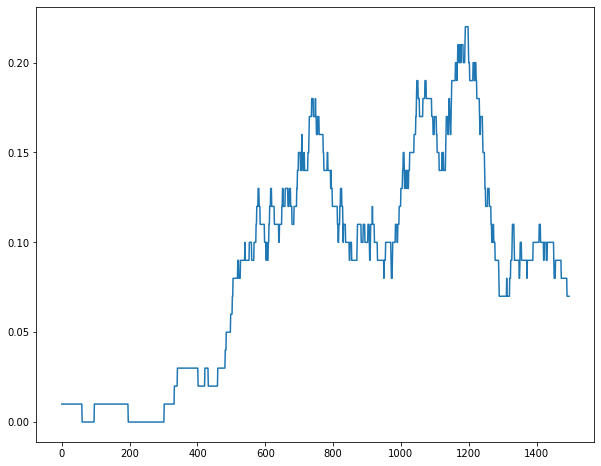

In [407]:
plt.plot(np.convolve(np.asarray([x[0] for x in STATS['returns']]), np.ones((100,)) / 100, mode='valid'))

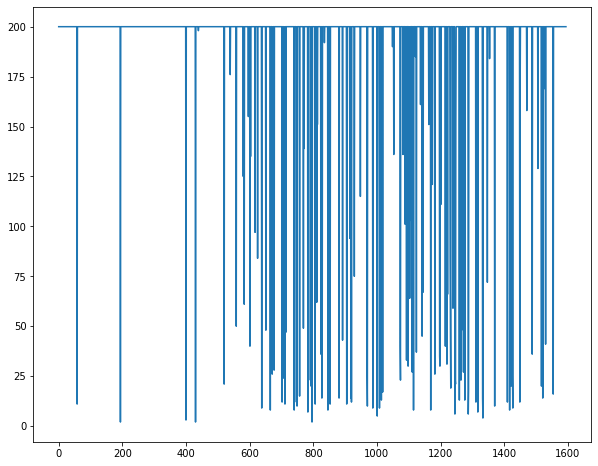

In [408]:
plt.plot(np.convolve(np.convolve(np.asarray([x[1] for x in STATS['returns']]), np.asarray([1, -1]), mode='valid'), np.ones((1,)) / 1, mode='valid'))

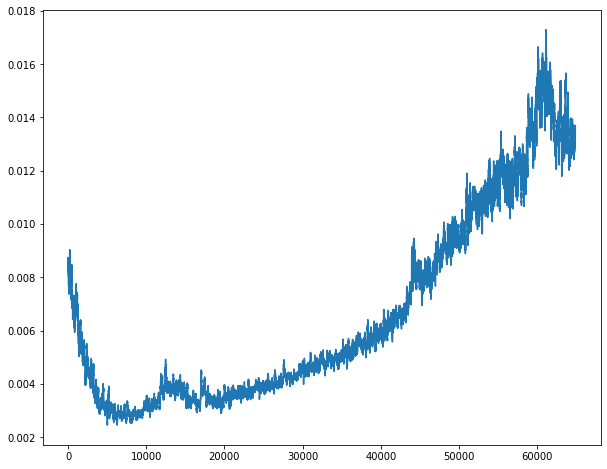

In [409]:
plt.plot(np.convolve(np.asarray(STATS['loss']), np.ones((100,)) / 100, mode='valid')[10000:])

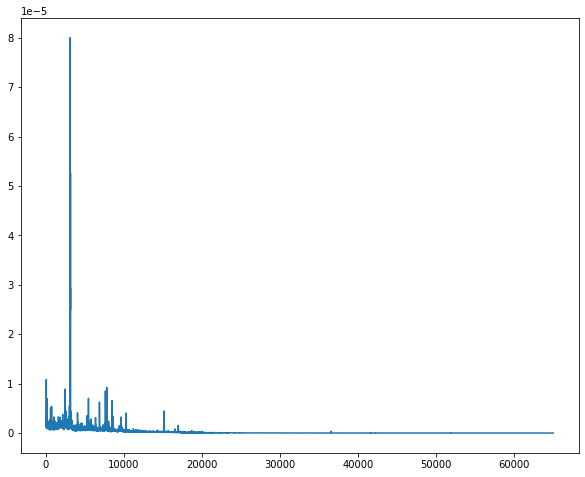

In [410]:
plt.plot(np.convolve(np.asarray(STATS['curiosity_loss']), np.ones((10,)) / 10, mode='valid')[10000:])

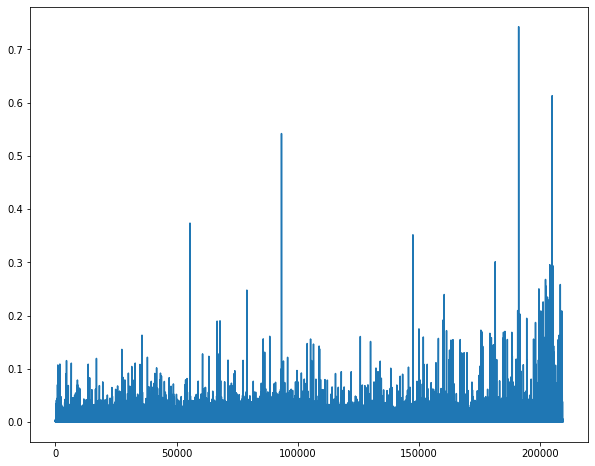

In [381]:
plt.plot(buffer.tree.tree[buffer.tree.tree_idx(0):buffer.tree.tree_idx(buffer.tree.n_entries)-500])

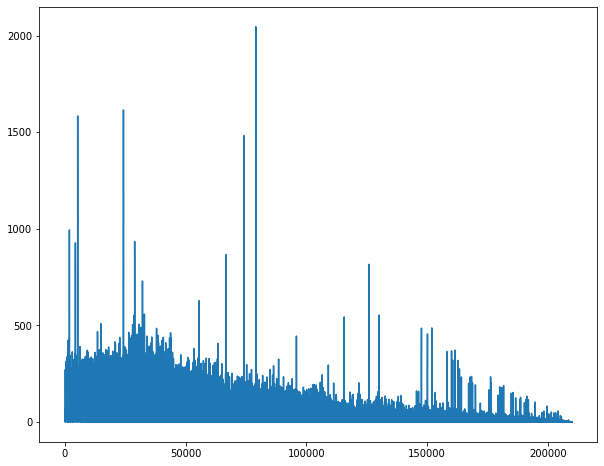

In [382]:
plt.plot(buffer.tree.n_samples[0:buffer.tree.n_entries])# * buffer.tree.tree[buffer.tree.tree_idx(0):buffer.tree.tree_idx(buffer.tree.n_entries)])

In [254]:
buffer.tree.n_samples[0:buffer.tree.n_entries-500].min()

0.0

In [167]:
buffer.tree.total()

60.97743276334939

In [168]:
observation = buffer.sample_batch(1)[0][2][0]

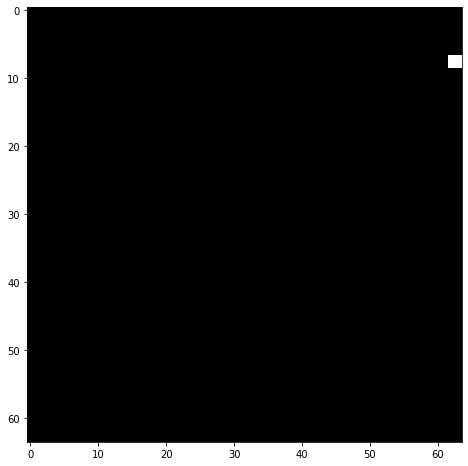

In [338]:
plt.imshow(observation)

In [339]:
# scale the obs, change to model shape
image = torch.from_numpy(to_batch_shape(observation)).permute((0, 3, 1, 2)).cuda() / 255
with torch.no_grad():
    outputs = model(image)
    action = torch.argmax(outputs).item()

In [340]:
outputs, action

(tensor([[0.1875, 0.2060, 0.1942, 0.1906]], device='cuda:0'), 1)

In [95]:
# evaluate the model on all possible states, then tally up the error

# generate all possible states, and calculate their distance
states = []
for i in range(62):
    for j in range(62):
        observation = np.zeros((64, 64, 3), dtype=np.uint8)
        observation[i:i+2, j:j+2] = np.array([255, 255, 255])
        distance = abs(32 - i) + abs(32-j)
        states.append((observation, distance, (i, j)))

In [96]:
short_states = [x for x in states if x[1] < 3]

In [169]:
loss = 0

for s, distance, coord in short_states:
    image = torch.from_numpy(to_batch_shape(s)).permute((0, 3, 1, 2)).cuda() / 255
    with torch.no_grad():
        outputs = model(image)
        q_n, a_n = torch.max(outputs, 1)
        q_n = q_n.item()
        print(outputs, distance, coord)
    
    loss += abs(0.99 - q_n)
loss

tensor([[0.2452, 0.1776, 0.4034, 0.3412]], device='cuda:0') 2 (30, 32)
tensor([[ 0.2830,  0.5781,  0.2916, -0.2238]], device='cuda:0') 2 (31, 31)
tensor([[0.2936, 0.4660, 0.8937, 0.2513]], device='cuda:0') 1 (31, 32)
tensor([[0.2709, 0.3548, 0.6788, 0.4546]], device='cuda:0') 2 (31, 33)
tensor([[0.1838, 0.3206, 0.1947, 0.1905]], device='cuda:0') 2 (32, 30)
tensor([[ 0.2196,  0.6174,  0.4142, -0.3521]], device='cuda:0') 1 (32, 31)
tensor([[0.6539, 0.4541, 0.6233, 0.3233]], device='cuda:0') 0 (32, 32)
tensor([[0.4249, 0.2543, 0.3013, 0.8590]], device='cuda:0') 1 (32, 33)
tensor([[0.3762, 0.2627, 0.3331, 0.7338]], device='cuda:0') 2 (32, 34)
tensor([[0.5723, 0.4668, 0.4592, 0.0938]], device='cuda:0') 2 (33, 31)
tensor([[1.0547, 0.4611, 0.3957, 0.1075]], device='cuda:0') 1 (33, 32)
tensor([[0.5799, 0.3112, 0.3298, 0.6955]], device='cuda:0') 2 (33, 33)
tensor([[0.7343, 0.3906, 0.3466, 0.3306]], device='cuda:0') 2 (34, 32)


4.203874721527101

In [411]:
sum_obs = np.zeros((64, 64, 3))
for sarsd in buffer.tree.data:
    if not sarsd:
        break
    sum_obs += sarsd[0]

In [412]:
sum_obs = np.log(sum_obs)
sum_obs /= sum_obs.max()

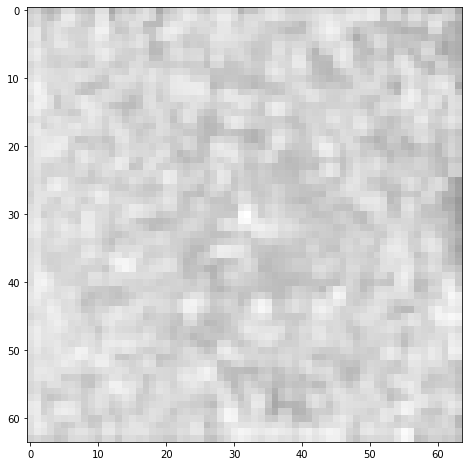

In [413]:
plt.imshow(sum_obs)

In [414]:
# evaluate the model on all possible states, then display the return
sum_obs = np.zeros((64, 64))

# generate all possible states, and calculate their return
states = []
for i in range(64):
    for j in range(64):
        observation = np.zeros((64, 64, 3), dtype=np.uint8)
        observation[i:i+2, j:j+2] = np.array([255, 255, 255])
        image = torch.from_numpy(to_batch_shape(observation)).permute((0, 3, 1, 2)).cuda() / 255
        with torch.no_grad():
            outputs = model(image)
            q_n, a_n = torch.max(outputs, 1)
        sum_obs[i, j] = q_n.item()

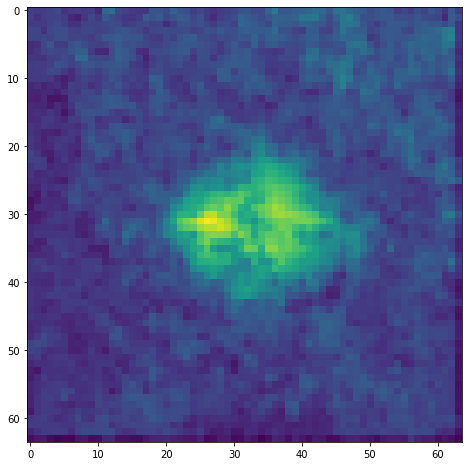

In [415]:
plt.imshow(sum_obs)

In [416]:
sum_obs.max(), sum_obs.min(), sum_obs.mean()

(1.14337158203125, 0.1785285472869873, 0.41782389738364145)